In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

# Dataset Loading

In [3]:
# โหลดไฟล์ .npy
images = np.load("../../data/processed_data/eng_numerals/images.npy")
labels = np.load("../../data/processed_data/eng_numerals/labels.npy")

# ตรวจสอบข้อมูล
print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels.shape}")


Shape of images: (20646, 32, 32)
Shape of labels: (20646,)


In [4]:
X = images
y = labels

print(X.shape)
print(y.shape)

print(np.min(X), np.max(X))


(20646, 32, 32)
(20646,)
0 255


In [5]:
# หา missing value
np.isnan(X).sum() 

0

In [6]:
print(np.unique(y))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]


# Visualization

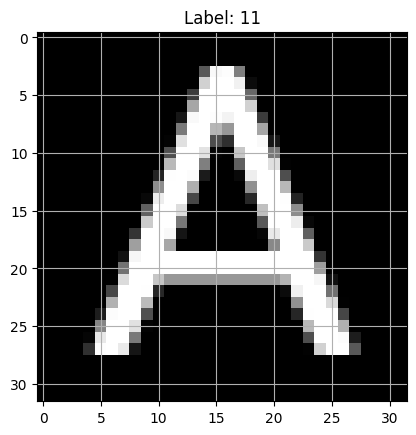

In [9]:
# แสดงภาพเดี่ยว(Single Image)
# แสดงภาพตัวอย่างแรก
plt.imshow(images[0], cmap="gray")
plt.title(f"Label: {labels[0]}")
plt.axis("on")  # ซ่อนแกน
plt.grid()
plt.show()


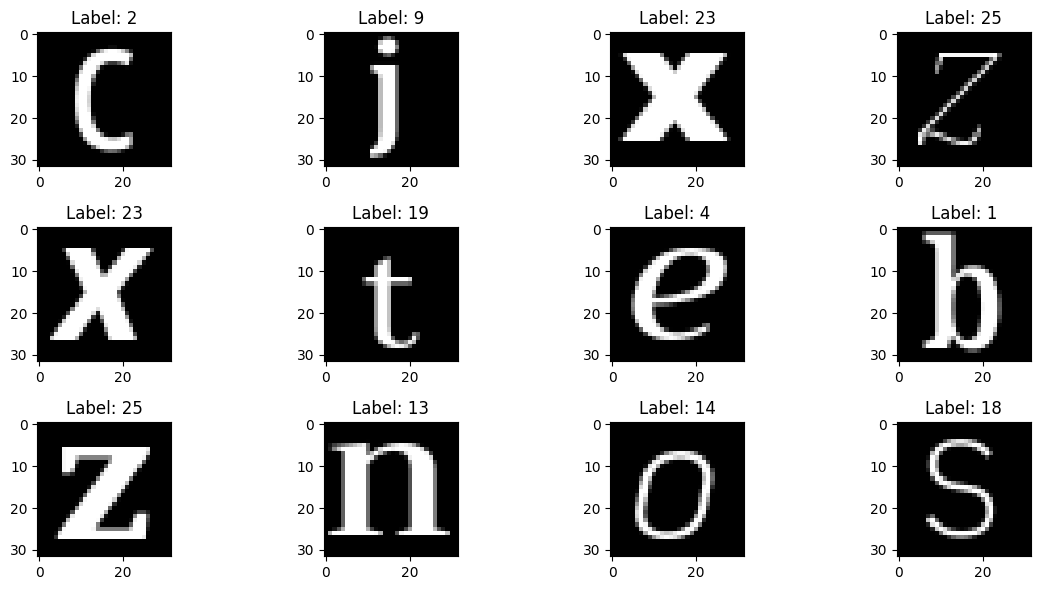

In [8]:
# ตั้งค่าจำนวนภาพที่ต้องการแสดง
num_images = 12  # จำนวนภาพทั้งหมดที่ต้องการแสดง
num_cols = 4     # จำนวนคอลัมน์
num_rows = num_images // num_cols

# สร้างกริดภาพ
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i], cmap="gray")
        ax.set_title(f"Label: {labels[i]}")
        ax.axis("on")

plt.tight_layout()
plt.show()

### ตรวจสอบความสมดุลของคลาส (Class Distribution)

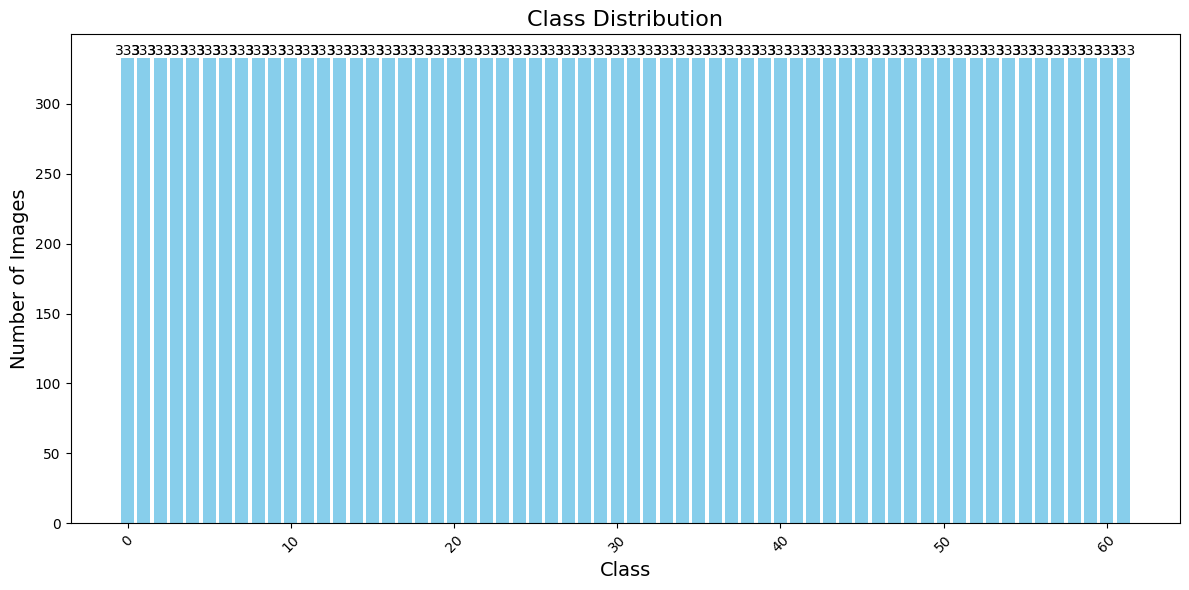

In [11]:
from collections import Counter

# นับจำนวนคลาส
class_counts = Counter(labels)

# จัดเรียงข้อมูลคลาสตามจำนวนตัวอย่าง (จากมากไปน้อย)
sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))


# แสดงกราฟแท่ง
plt.figure(figsize=(12, 6))  # ปรับขนาดกราฟ
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
plt.title("Class Distribution", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, fontsize=10)  # หมุนชื่อคลาส 45 องศา
plt.tight_layout()

# เพิ่มตัวเลขบนแท่งกราฟ
for key, value in sorted_counts.items():
    plt.text(key, value, str(value), ha='center', va='bottom')

plt.show()


## Train-test Split

In [12]:
# แบ่ง Train และ Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ตรวจสอบขนาดข้อมูล
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 16516, Test size: 4130


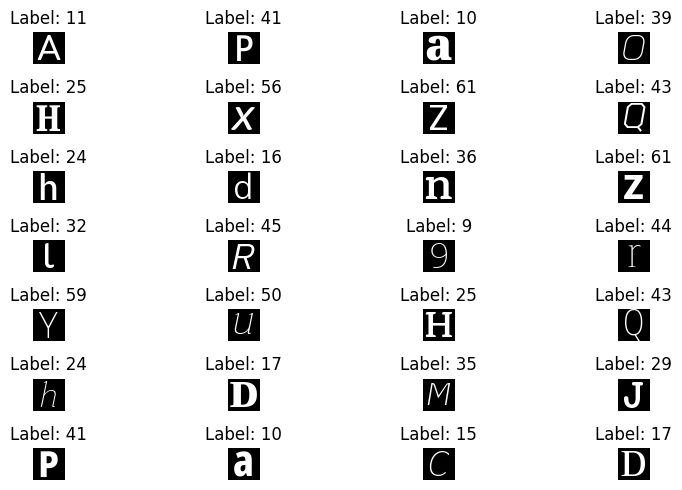

In [13]:
# ตั้งค่าจำนวนภาพที่ต้องการแสดง
num_images = 30  # จำนวนภาพทั้งหมดที่ต้องการแสดง
num_cols = 4     # จำนวนคอลัมน์
num_rows = num_images // num_cols

# สร้างกริดภาพ
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 5))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(X_train[i], cmap="gray")
        ax.set_title(f"Label: {y_train[i]}")
        ax.axis("off")

plt.tight_layout()
plt.show()

In [14]:
print(X_train.shape)
print(X_test.shape)

(16516, 32, 32)
(4130, 32, 32)


## Prepare Dataset (Re-shape the Structure)

In [15]:
X_train = np.expand_dims(X_train, -1)     # run only Once! or  np.squeeze(X_train)
X_test = np.expand_dims(X_test, -1)

In [16]:
# Normalize
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [17]:
# Normalize Check
np.min(X_train), np.max(X_train)

(0.0, 1.0)

In [18]:
X_train.shape

(16516, 32, 32, 1)

In [19]:
print('Train: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test: X={}, y={}'.format(X_test.shape, y_test.shape))

Train: X=(16516, 32, 32, 1), y=(16516,)
Test: X=(4130, 32, 32, 1), y=(4130,)


# Create Model

In [20]:
num_classes = len(np.unique(y_train))
num_classes

62

In [21]:
in_shape = X_train.shape[1:]
in_shape

(32, 32, 1)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# สร้างโมเดล CNN
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=in_shape),  # 32 filters, 3x3 kernel
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # ลดขนาดภาพลงครึ่งหนึ่ง

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # 64 filters
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # 128 filters
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten และ Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),  # Fully Connected Layer
    Dropout(0.5),  # ลด Overfitting
    Dense(num_classes, activation='softmax')  # Output Layer สำหรับ 62 คลาส
])

# สรุปโครงสร้างโมเดล
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                        

In [25]:
'''
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
'''

"\nmodel.compile(optimizer='adam', \n              loss='sparse_categorical_crossentropy', \n              metrics=['accuracy'])\n"

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
import time
from tensorflow.keras.callbacks import EarlyStopping

start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=32, 
                    epochs=100,
                    #validation_data=(X_test, y_test),
                    validation_split=0.20,
                    callbacks=[early_stopping], verbose=1,)

end = time.time()

print("Time Taken: {:.2f} minutes".format((end - start)/60))

Epoch 1/100
413/413 [==============================] - 9s 6ms/step - loss: 1.8970 - accuracy: 0.4834 - val_loss: 1.2636 - val_accuracy: 0.6504
Epoch 2/100
413/413 [==============================] - 2s 5ms/step - loss: 0.6102 - accuracy: 0.7978 - val_loss: 0.1150 - val_accuracy: 0.9634
Epoch 3/100
413/413 [==============================] - 2s 5ms/step - loss: 0.3903 - accuracy: 0.8663 - val_loss: 0.0896 - val_accuracy: 0.9664
Epoch 4/100
413/413 [==============================] - 2s 5ms/step - loss: 0.2880 - accuracy: 0.9011 - val_loss: 0.0695 - val_accuracy: 0.9737
Epoch 5/100
413/413 [==============================] - 2s 6ms/step - loss: 0.2417 - accuracy: 0.9133 - val_loss: 0.0759 - val_accuracy: 0.9706
Epoch 6/100
413/413 [==============================] - 2s 5ms/step - loss: 0.2351 - accuracy: 0.9163 - val_loss: 0.0566 - val_accuracy: 0.9812
Epoch 7/100
413/413 [==============================] - 2s 5ms/step - loss: 0.1977 - accuracy: 0.9302 - val_loss: 0.0694 - val_accuracy: 0.9782

In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


130/130 [==============================] - 0s 3ms/step - loss: 0.0596 - accuracy: 0.9821
Test Accuracy: 98.21%


### รายละเอียดของกราฟ
Loss:

-Train Loss: แสดงว่าโมเดลเรียนรู้ข้อมูล Training ได้ดีแค่ไหน

-Validation Loss: ช่วยบอกว่าโมเดลเรียนรู้ข้อมูลใหม่ (ที่ไม่เคยเห็นมาก่อน) ได้ดีแค่ไหน

-Validation Loss ที่ลดลงต่อเนื่องแสดงว่าโมเดลยังเรียนรู้ได้ดี แต่ถ้าเพิ่มขึ้นอาจบ่งชี้ว่า Overfitting

Accuracy:

-Train Accuracy: ความแม่นยำของโมเดลบนข้อมูล Training

-Validation Accuracy: ความแม่นยำของโมเดลบนข้อมูล Validation

-ค่า Accuracy ที่ใกล้เคียงกันระหว่าง Train และ Validation หมายถึงโมเดลกำลังเรียนรู้ได้ดี


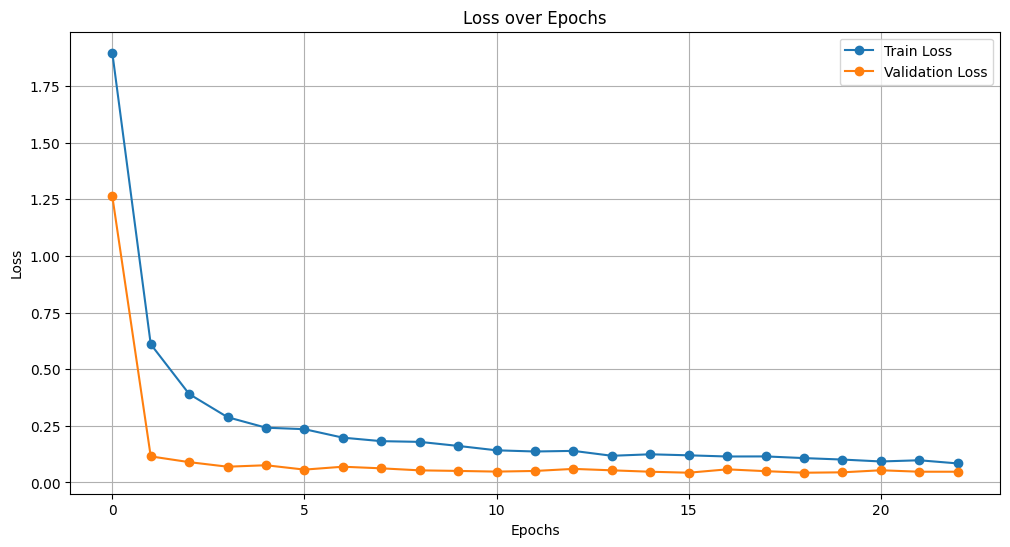

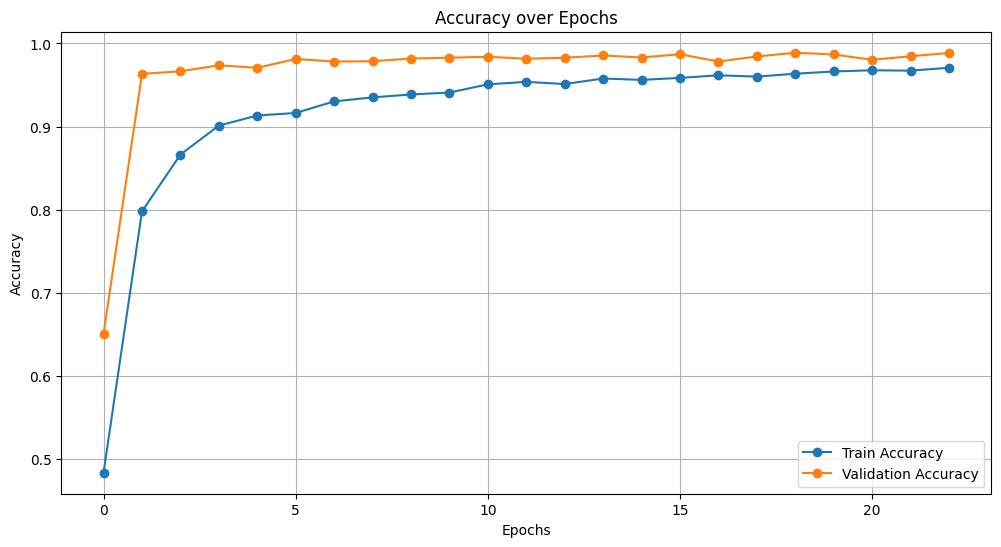

In [26]:
# ดึงข้อมูล Loss และ Accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# สร้างกราฟ Loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# สร้างกราฟ Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## Confusion Matrix

130/130 [==============================] - 0s 2ms/step


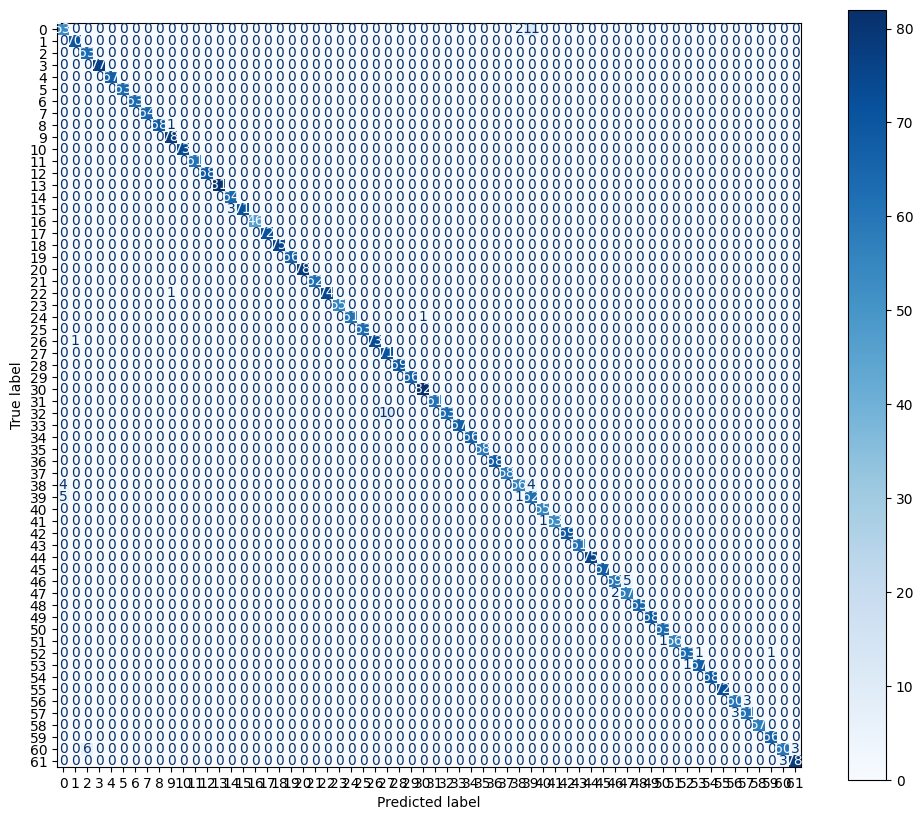

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ตรวจสอบว่า y_test เป็น One-Hot หรือไม่
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # กรณี One-Hot
    y_true = y_test.argmax(axis=1)
else:  # กรณี Label ธรรมดา
    y_true = y_test

# ทำนายผล
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# สร้าง Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# สร้างกราฟและปรับขนาด
plt.figure(figsize=(12, 10))  # กำหนดขนาดกว้าง 10 นิ้ว สูง 8 นิ้ว
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(62))
disp.plot(cmap='Blues', ax=plt.gca())  # ใช้ gca() เพื่อให้ plot อยู่ใน figure เดียวกัน
plt.show()



# Test Model

### ทำนายภาพเดี่ยว
ใช้ภาพใหม่ (เช่น ภาพที่ไม่ได้อยู่ในชุด Test) เพื่อทดสอบ:

In [31]:
# ตัวเลข 0-9
numbers = [str(i) for i in range(10)]  # ['0', '1', ..., '9']

# ตัวอักษร a-z และ A-Z
lowercase = [chr(i) for i in range(ord('a'), ord('z') + 1)]  # ['a', 'b', ..., 'z']
uppercase = [chr(i) for i in range(ord('A'), ord('Z') + 1)]  # ['A', 'B', ..., 'Z']

# สร้างลำดับ a, A, b, B, ...
letters = [val for pair in zip(lowercase, uppercase) for val in pair]

# รวมตัวเลขและตัวอักษรทั้งหมด
all_characters_class = numbers + letters

1/1 [==============================] - 0s 27ms/step


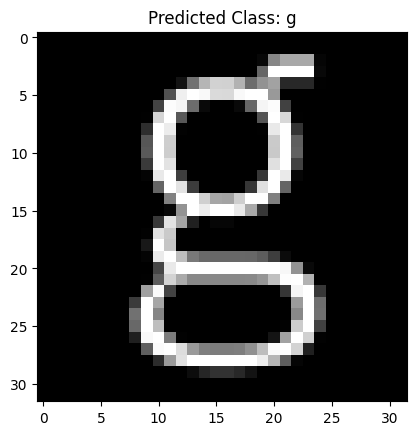

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# โหลดภาพใหม่
new_image = cv2.imread("../../data/raw_images/eng_upper_lowercase/g_L/g_4.png", cv2.IMREAD_GRAYSCALE)
new_image = cv2.resize(new_image, (32, 32))  # ปรับขนาดให้ตรงกับ Input Shape
#new_image = 255 - new_image # Invert สี
new_image = new_image / 255.0  # Normalization
new_image = np.expand_dims(new_image, axis=(0, -1))  # เพิ่มมิติให้ตรงกับโมเดล

# ทำนายคลาส
prediction = model.predict(new_image)
predicted_class = np.argmax(prediction)

# แสดงผล
plt.imshow(new_image.squeeze(), cmap='gray')
#plt.title(f"Predicted Class: {predicted_class}")
plt.title(f"Predicted Class: {all_characters_class[predicted_class]}")
plt.axis("on")
plt.show()


### ทดสอบหลายภาพ
ถ้ามีหลายภาพใหม่ในโฟลเดอร์:

In [ ]:
from pathlib import Path

new_images = []
image_folder = Path("../../data/output_images/output_characters")
['.png', '.jpg', '.jpeg']
# โหลดภาพใหม่ทั้งหมด
for image_path in image_folder.glob("*.*"):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (32, 32))
    #img = 255 - img # Invert สี
    img = img / 255.0 # Normalization
    new_images.append(np.expand_dims(img, axis=-1))

new_images = np.array(new_images)

# ทำนายผลลัพธ์
predictions = model.predict(new_images)
predicted_classes = np.argmax(predictions, axis=1)

# กำหนดจำนวนแถวและคอลัมน์
num_cols = 8 # จำนวนคอลัมน์
num_rows = len(new_images) // num_cols + (len(new_images) % num_cols > 0)  # คำนวณจำนวนแถว

# สร้าง Grid Layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3))  # ปรับขนาด Layout

for i, ax in enumerate(axes.flat):
    if i < len(new_images):
        ax.imshow(new_images[i].squeeze(), cmap='gray')
        ax.set_title(f"Predicted: {all_characters_class[predicted_classes[i]]}")
        ax.axis("on")
    else:
        ax.axis("off")  # ซ่อนช่องว่างที่ไม่มีภาพ

plt.tight_layout()
plt.show()


### ใช้ Metric เพิ่มเติม
Precision, Recall, F1-Score
วัดประสิทธิภาพของโมเดลในแต่ละคลาส:

-Precision: โฟกัสที่ความถูกต้องของการทำนาย Positive

-Recall: โฟกัสที่ความครบถ้วนของการจับ Positive

-F1-Score: สมดุลระหว่าง Precision และ Recall

-Macro Avg: ค่าเฉลี่ยที่ให้ความสำคัญเท่ากันทุกคลาส ไม่สนใจ Support

-Weighted Avg: ค่าเฉลี่ยที่คำนึงถึงขนาดของคลาส เหมาะกับข้อมูลไม่สมดุล

-ใช้ Macro เมื่อทุกคลาสสำคัญเท่ากัน และ Weighted เมื่อต้องการสะท้อนความสำคัญของข้อมูลทั้งชุด

In [35]:
from sklearn.metrics import classification_report

# รายงานผลการทำนาย
print(classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(62)]))  # ปรับ range ตามจำนวนคลาส

              precision    recall  f1-score   support

           0       0.85      0.80      0.83        66
           1       0.99      1.00      0.99        70
           2       0.91      1.00      0.95        63
           3       1.00      1.00      1.00        77
           4       1.00      1.00      1.00        67
           5       1.00      1.00      1.00        63
           6       1.00      1.00      1.00        63
           7       1.00      1.00      1.00        64
           8       1.00      0.99      0.99        69
           9       0.97      1.00      0.99        78
          10       1.00      1.00      1.00        73
          11       1.00      1.00      1.00        61
          12       1.00      1.00      1.00        68
          13       1.00      1.00      1.00        81
          14       0.96      1.00      0.98        64
          15       1.00      0.96      0.98        74
          16       1.00      1.00      1.00        46
          17       1.00    

### การวิเคราะห์ตัวอย่างที่โมเดลทำนายผิด
แสดงภาพที่โมเดลทำนายผิด

In [ ]:
import numpy as np

# หา Index ของภาพที่ทำนายผิด
incorrect_indices = np.where(y_true != y_pred_classes)[0]

# แสดงภาพตัวอย่างที่โมเดลทำนายผิด
for i in incorrect_indices[:10]:  # แสดง 10 ตัวอย่างแรก
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title(f"True: {y_true[i]}, Predicted: {all_characters_class[y_pred_classes[i]]}")
    plt.axis("off")
    plt.show()


## Save Model

In [38]:
model.save('../../models/eng_numerals_model.h5')